In [1]:
# Importing required libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Printing Plots in Notebook
%matplotlib inline

# Ignoring warnings
warnings.filterwarnings('ignore')

In [2]:
# Datapath
DATA_SET_PATH = '/home/ashay/ASHAYKING/dataset/housing-prices'

In [3]:
train = pd.read_csv( DATA_SET_PATH + '/train.csv')
test = pd.read_csv( DATA_SET_PATH + '/test.csv')

In [4]:
# Now drop the  'Id' column as it's redundant for modeling
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print(train.shape)
print(test.shape)
train.head()

(1460, 80)
(1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### A Look at target : SalesPrice

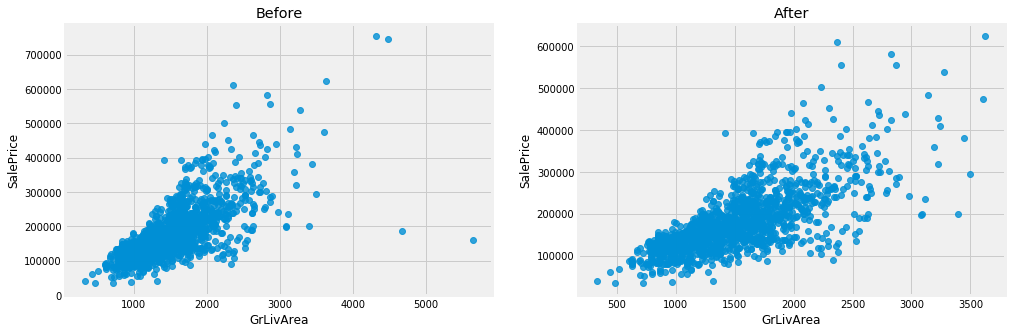

In [5]:
# Removing outlier from Dataset
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['GrLivArea']>4000)].index)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("After")

In [6]:
# First of all, save the length of the training and test data for use later
ntrain = train.shape[0]
ntest = test.shape[0]

TARGET = 'SalePrice'
# Also save the target value, as we will remove this
y_train = train[TARGET].values

# concatenate training and test data into all_data
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data shape: {}".format(all_data.shape))

all_data shape: (2915, 79)


### Pulling Missing ratio

In [7]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.725557
MiscFeature,96.397942
Alley,93.207547
Fence,80.445969
FireplaceQu,48.713551
LotFrontage,16.672384
GarageQual,5.454545
GarageCond,5.454545
GarageFinish,5.454545
GarageYrBlt,5.454545


In [8]:
# Removing featur with missing values > 80%
all_data.drop(['PoolQC','MiscFeature','Alley','Fence','Utilities'],inplace=True,axis=1)

In [9]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,3,1Fam,TA,No,706.0,0.0,GLQ,...,Normal,WD,0,Pave,8,856.0,0,2003,2003,2008
1,1262,0,0,3,1Fam,TA,Gd,978.0,0.0,ALQ,...,Normal,WD,0,Pave,6,1262.0,298,1976,1976,2007
2,920,866,0,3,1Fam,TA,Mn,486.0,0.0,GLQ,...,Normal,WD,0,Pave,6,920.0,0,2001,2002,2008
3,961,756,0,3,1Fam,Gd,No,216.0,0.0,ALQ,...,Abnorml,WD,0,Pave,7,756.0,0,1915,1970,2006
4,1145,1053,0,4,1Fam,TA,Av,655.0,0.0,GLQ,...,Normal,WD,0,Pave,9,1145.0,192,2000,2000,2008


In [10]:
# Using data description, fill these missing values with "None"
for col in ("FireplaceQu","GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
            "BsmtFinType2", "MSSubClass", "MasVnrType"):
    all_data[col] = all_data[col].fillna("None")

    
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Using data description, fill these missing values with 0 
for col in ("GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", 
           "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"):
    all_data[col] = all_data[col].fillna(0)
    
# Fill these features with their mode, the most commonly occuring value. This is okay since there are a low number of missing values for these features
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna(all_data['Functional'].mode()[0])

In [11]:
all_data_na = all_data.isnull().sum()
print("Features with missing values: ", all_data_na.drop(all_data_na[all_data_na == 0].index))

Features with missing values:  Series([], dtype: int64)


In [12]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [13]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF
0,856,854,0,3,1Fam,TA,No,706.0,0.0,GLQ,...,WD,0,Pave,8,856.0,0,2003,2003,2008,2566.0
1,1262,0,0,3,1Fam,TA,Gd,978.0,0.0,ALQ,...,WD,0,Pave,6,1262.0,298,1976,1976,2007,2524.0
2,920,866,0,3,1Fam,TA,Mn,486.0,0.0,GLQ,...,WD,0,Pave,6,920.0,0,2001,2002,2008,2706.0
3,961,756,0,3,1Fam,Gd,No,216.0,0.0,ALQ,...,WD,0,Pave,7,756.0,0,1915,1970,2006,2473.0
4,1145,1053,0,4,1Fam,TA,Av,655.0,0.0,GLQ,...,WD,0,Pave,9,1145.0,192,2000,2000,2008,3343.0


In [14]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Data columns (total 75 columns):
1stFlrSF         2915 non-null int64
2ndFlrSF         2915 non-null int64
3SsnPorch        2915 non-null int64
BedroomAbvGr     2915 non-null int64
BldgType         2915 non-null object
BsmtCond         2915 non-null object
BsmtExposure     2915 non-null object
BsmtFinSF1       2915 non-null float64
BsmtFinSF2       2915 non-null float64
BsmtFinType1     2915 non-null object
BsmtFinType2     2915 non-null object
BsmtFullBath     2915 non-null float64
BsmtHalfBath     2915 non-null float64
BsmtQual         2915 non-null object
BsmtUnfSF        2915 non-null float64
CentralAir       2915 non-null object
Condition1       2915 non-null object
Condition2       2915 non-null object
Electrical       2915 non-null object
EnclosedPorch    2915 non-null int64
ExterCond        2915 non-null object
ExterQual        2915 non-null object
Exterior1st      2915 non-null object
Exterior2nd      29

In [15]:
def plot_categorical(x,y,data):
    plt.subplots(figsize =(20, 5))
    
    plt.subplot(1, 3, 1)
    sns.boxplot(x=x, y=y, data=data);
    
    plt.subplot(1, 3, 2)
    sns.stripplot(x=x, y=y, data=data, size = 5, jitter = True);
    
    plt.subplot(1, 3, 3)
    sns.barplot(x=x, y=y, data=data);

In [16]:
numerical_features = all_data.select_dtypes(exclude=['object'])
categorical_features = all_data.select_dtypes(include=['object'])

### Handling Categorical Variable

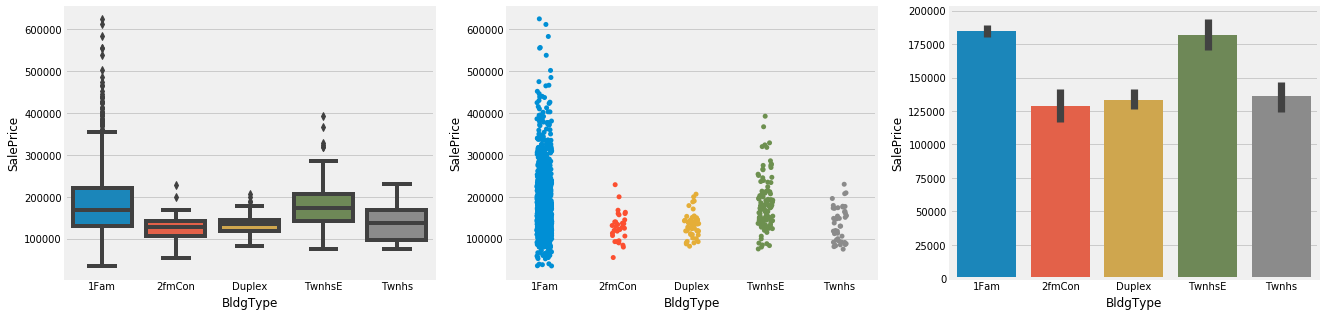

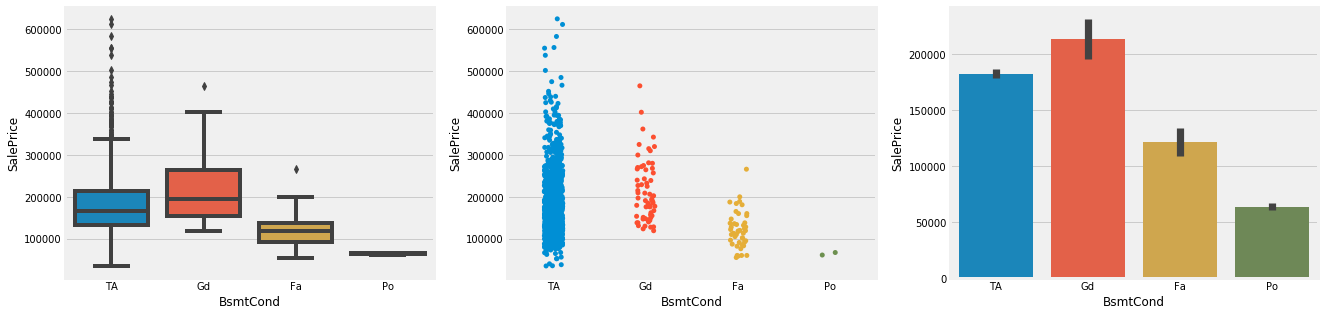

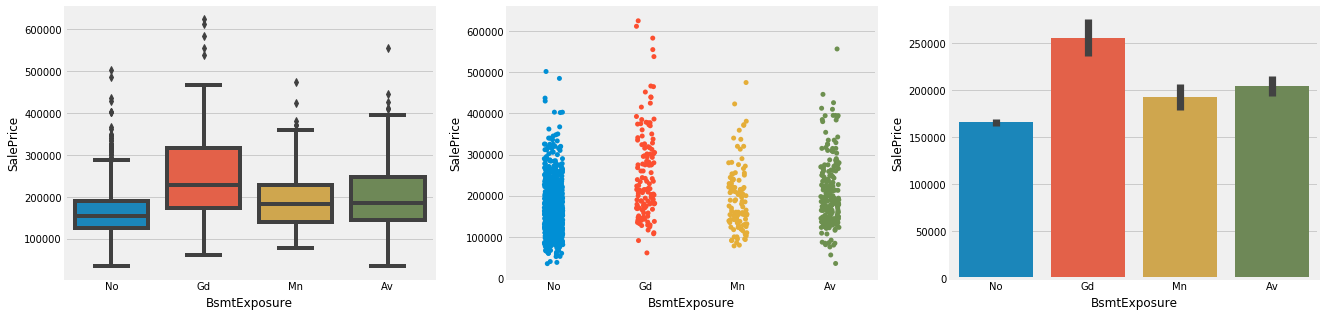

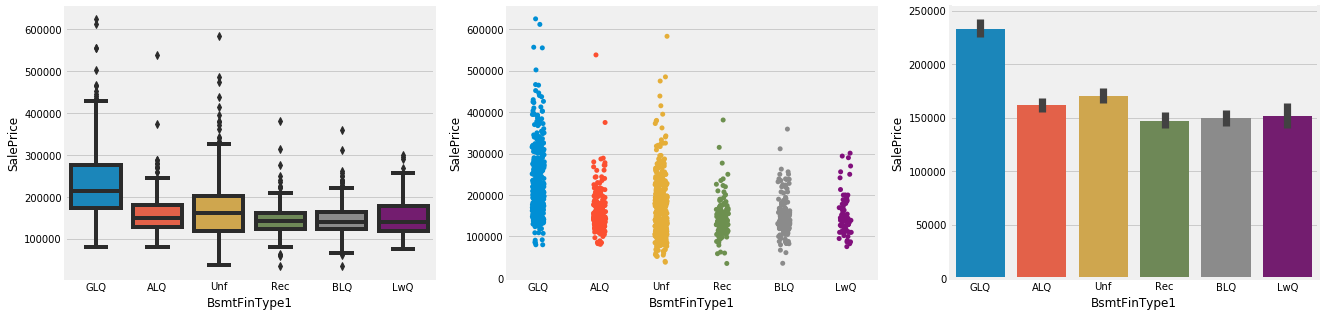

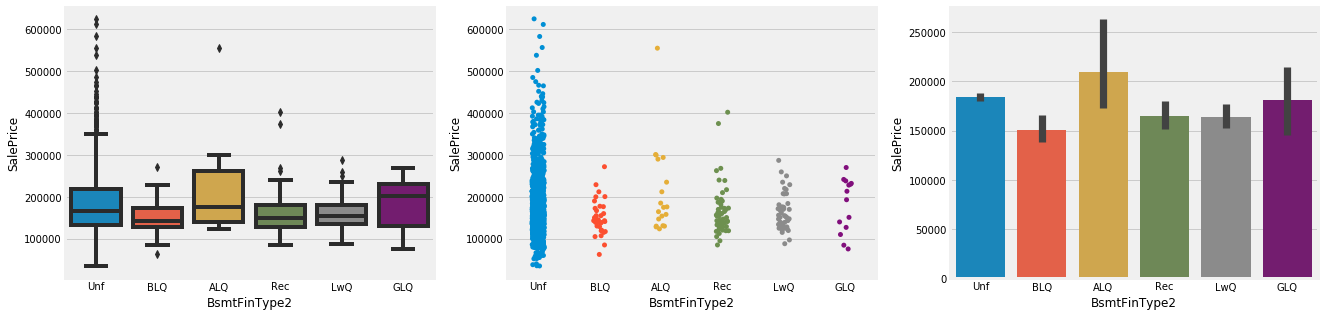

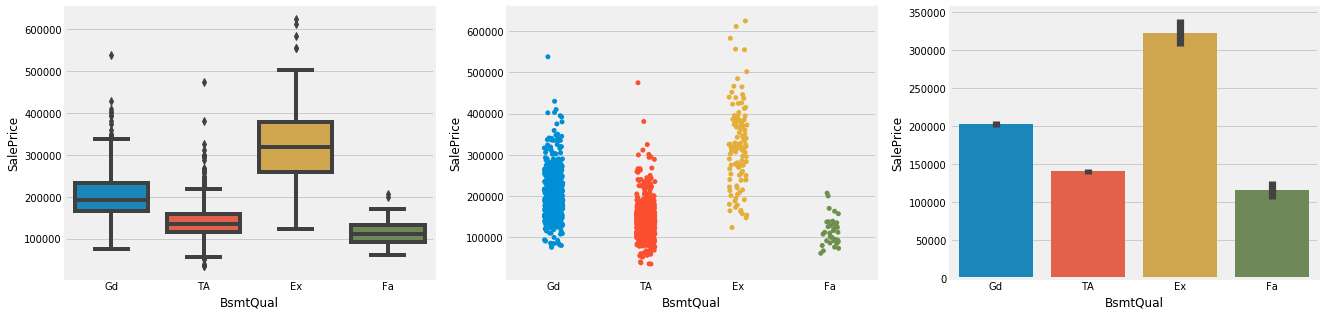

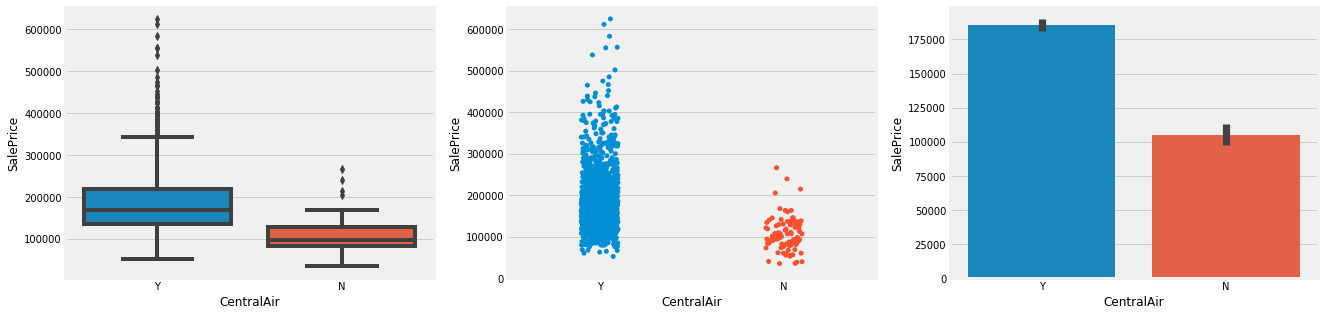

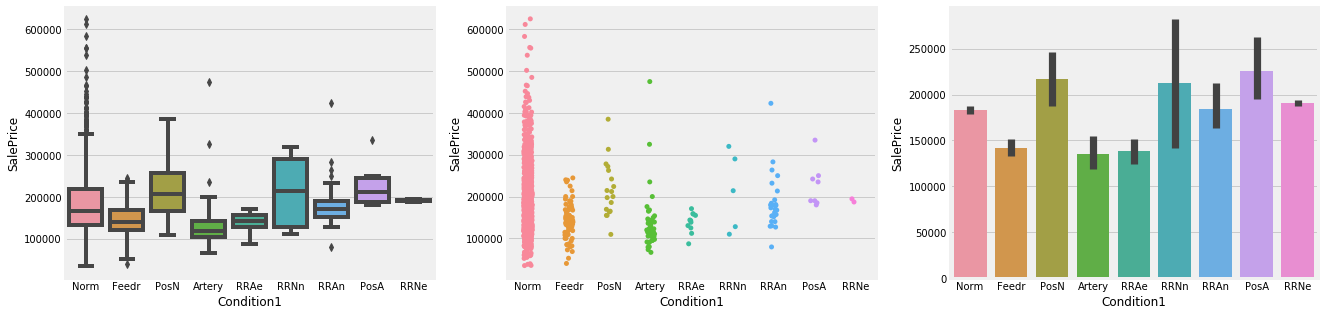

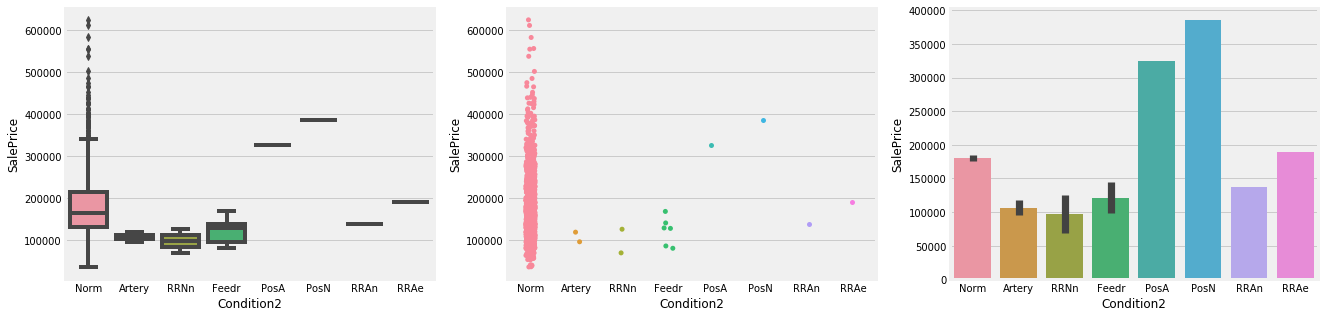

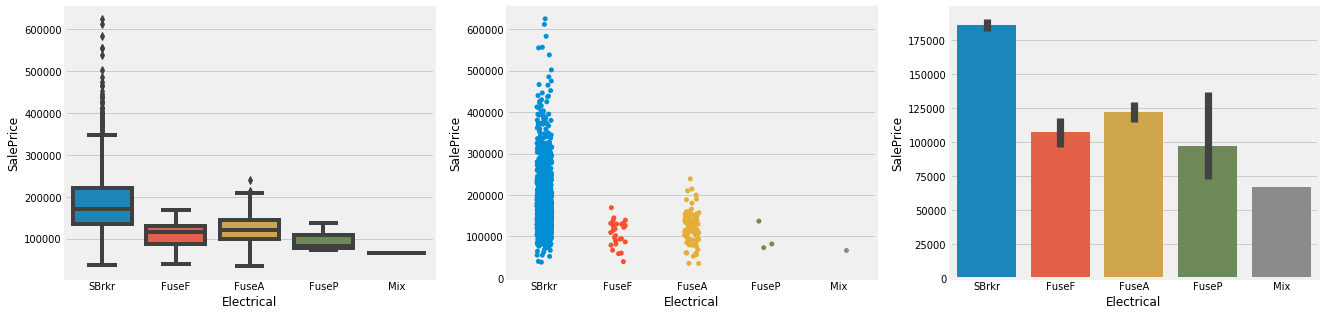

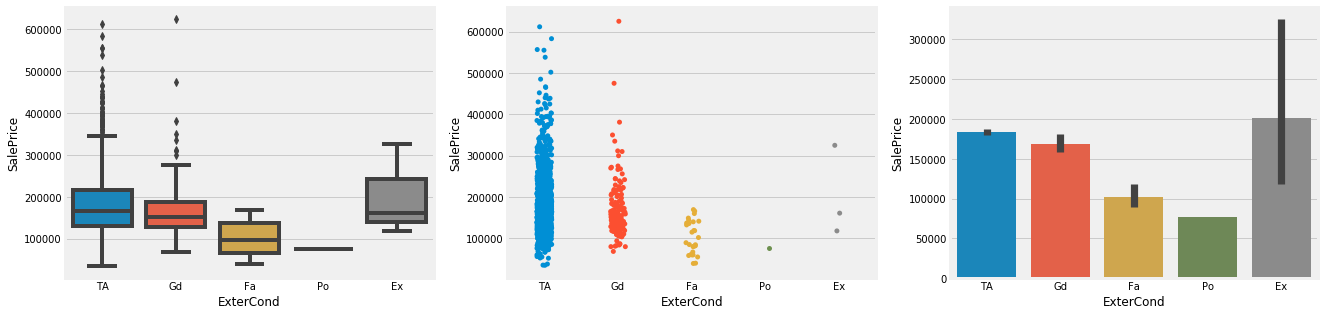

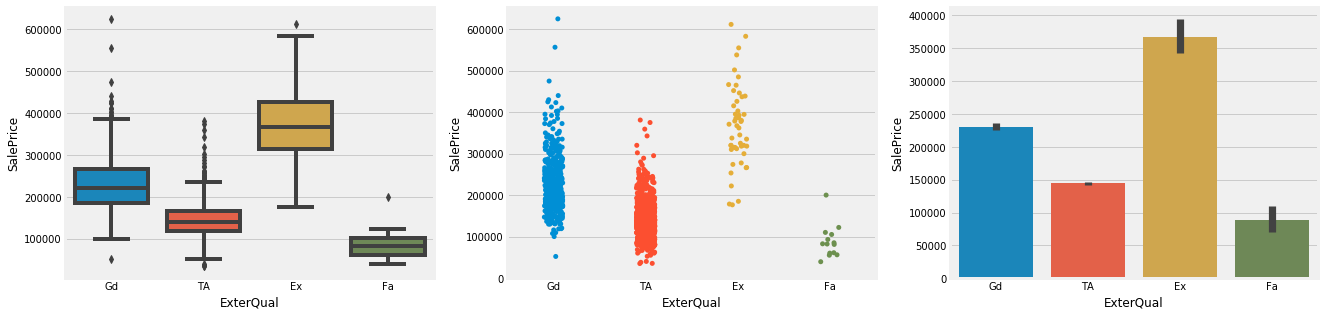

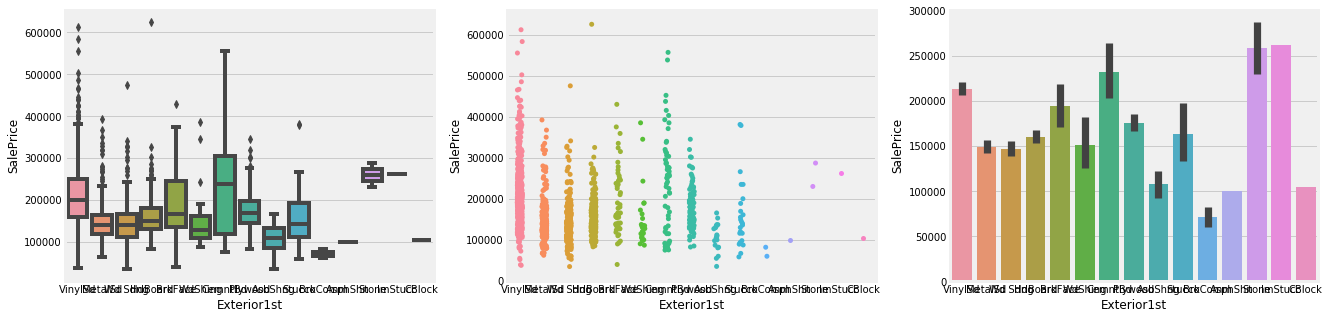

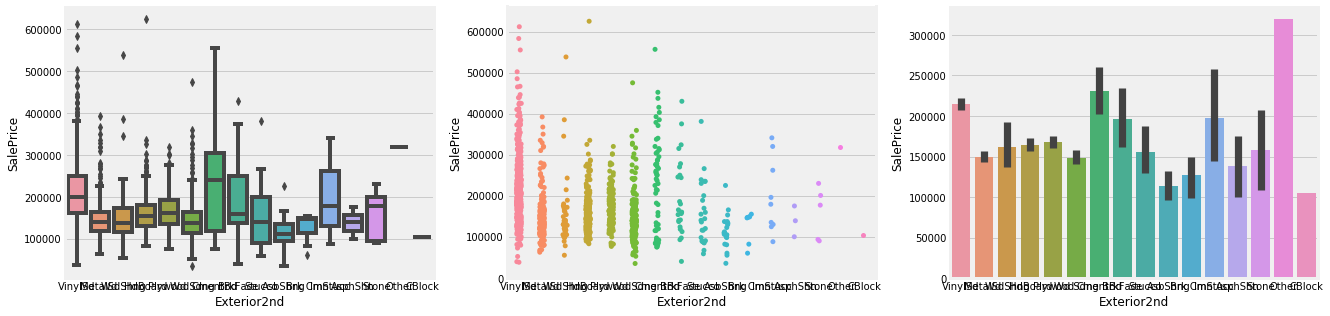

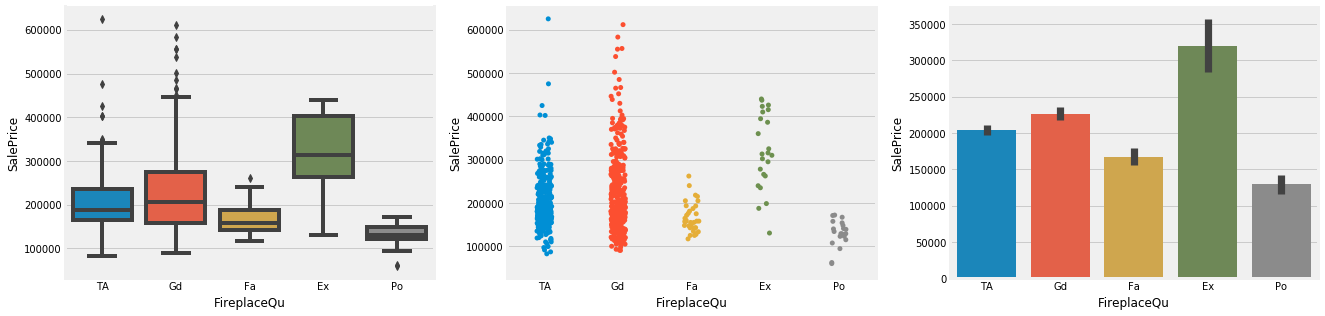

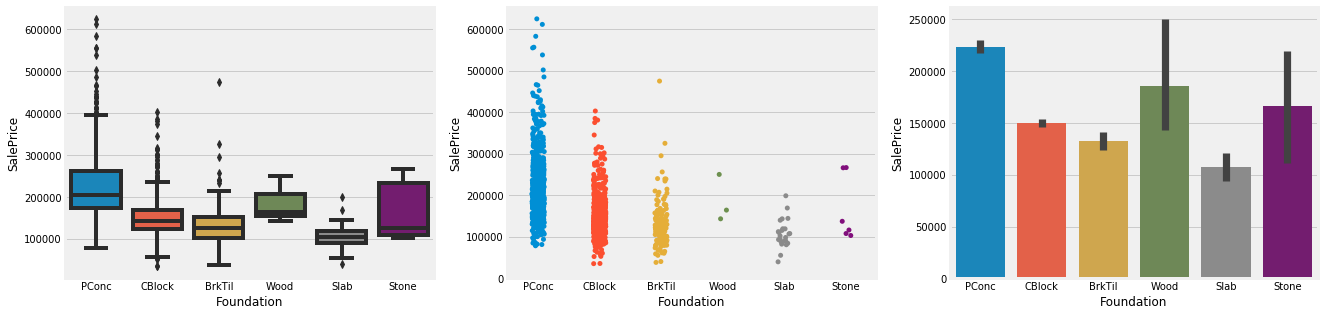

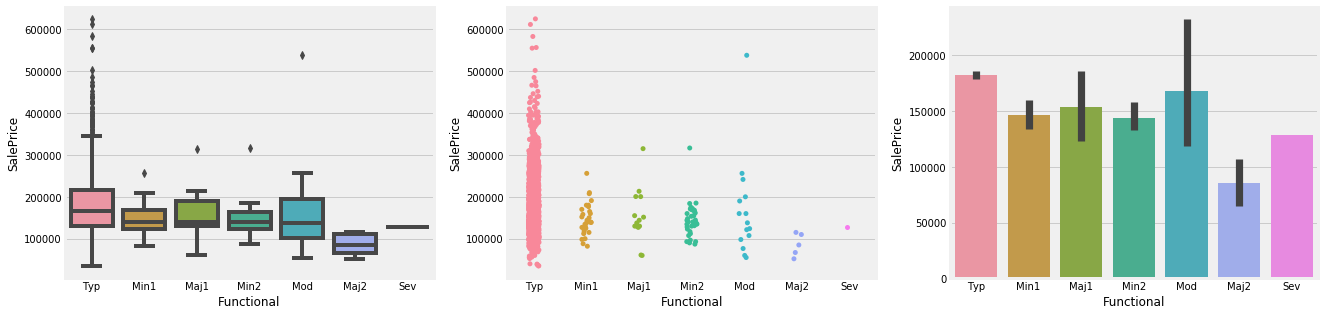

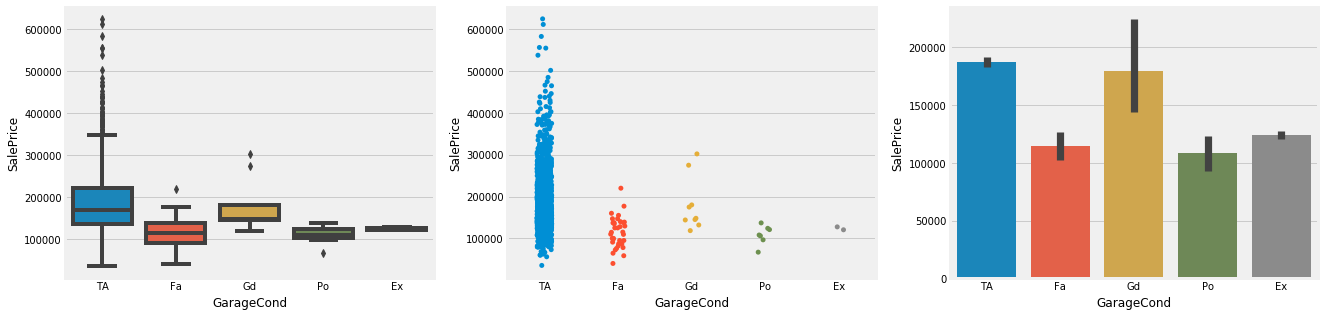

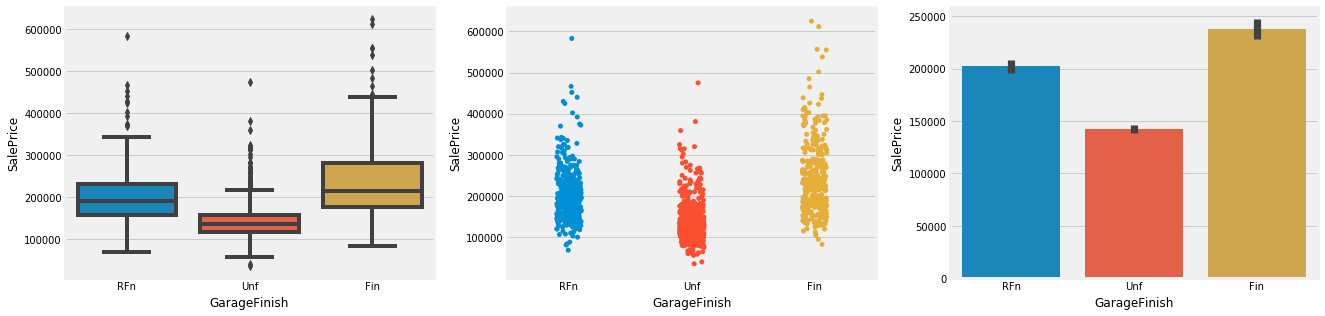

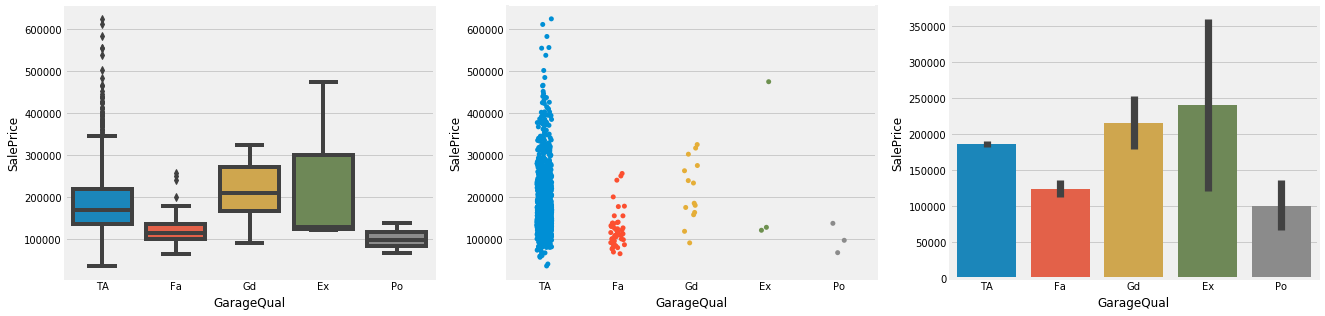

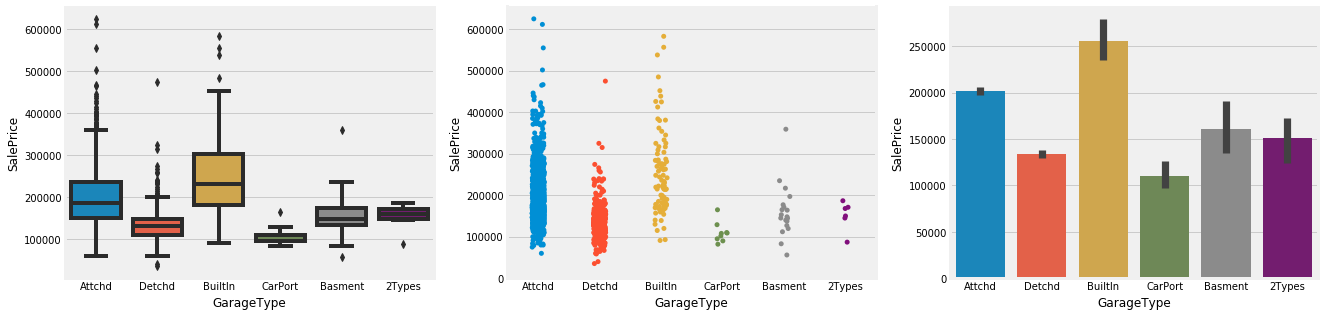

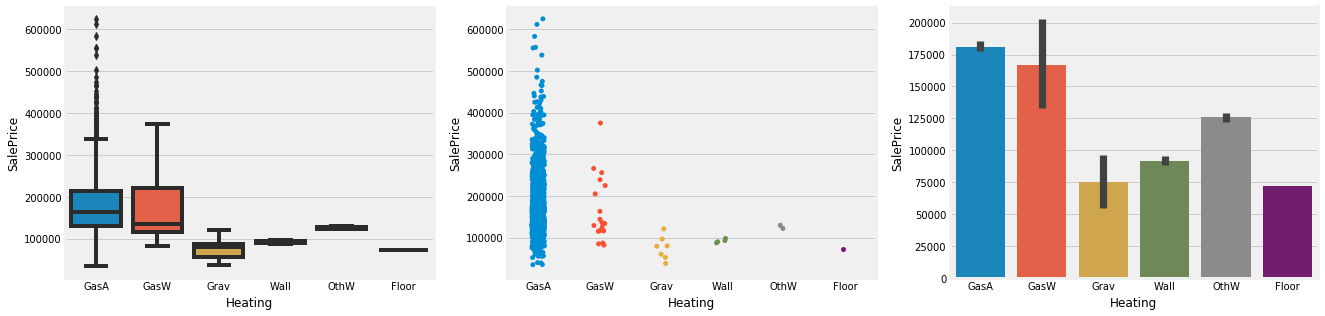

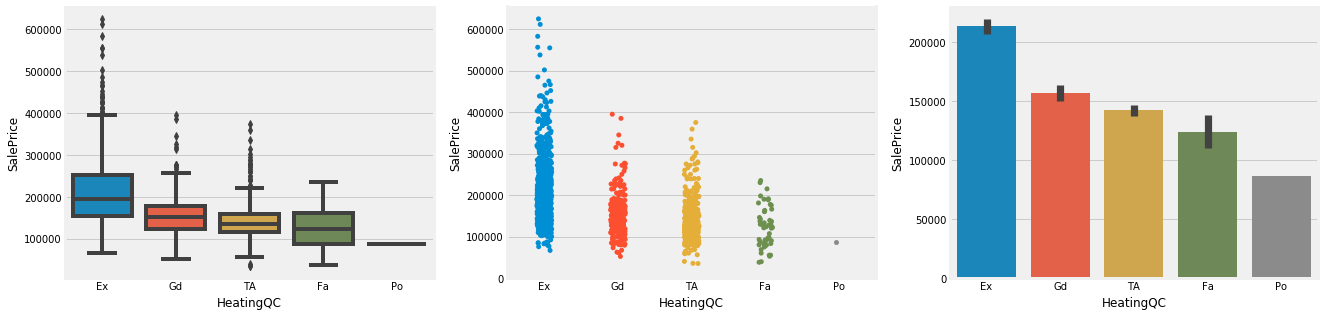

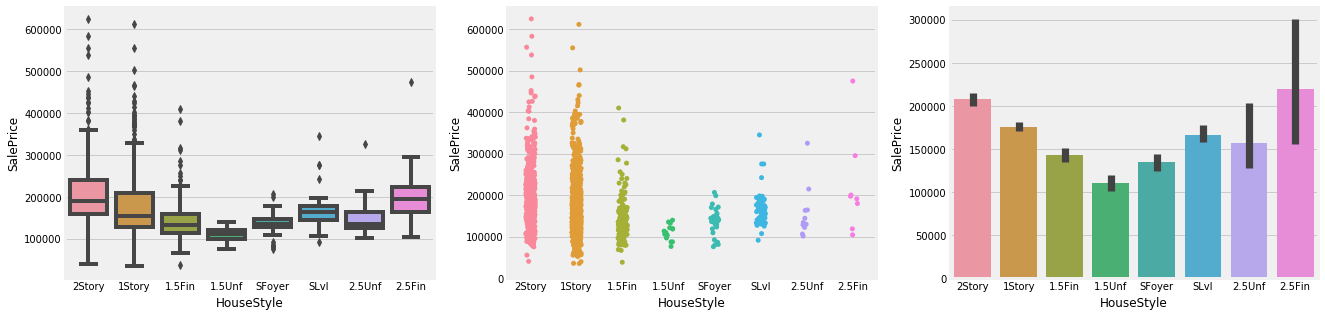

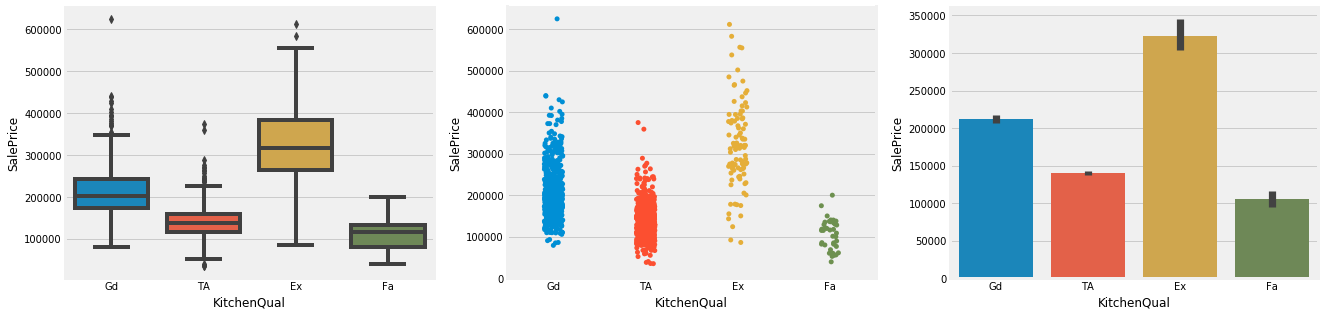

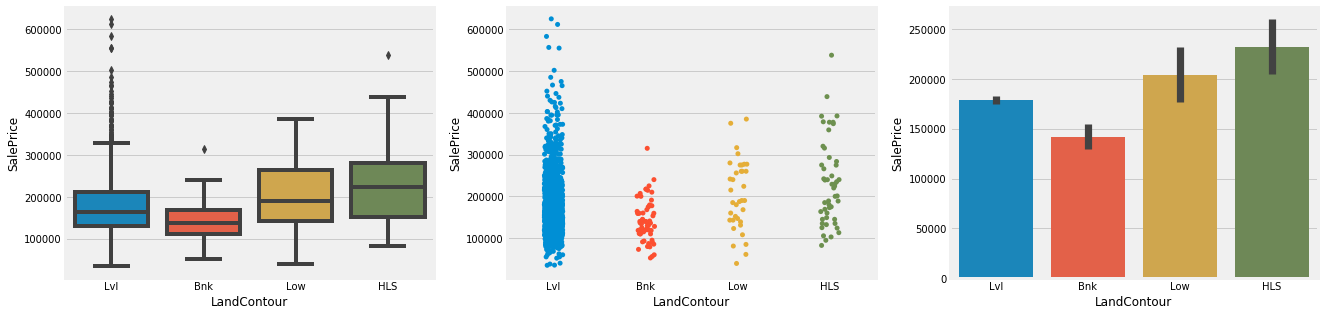

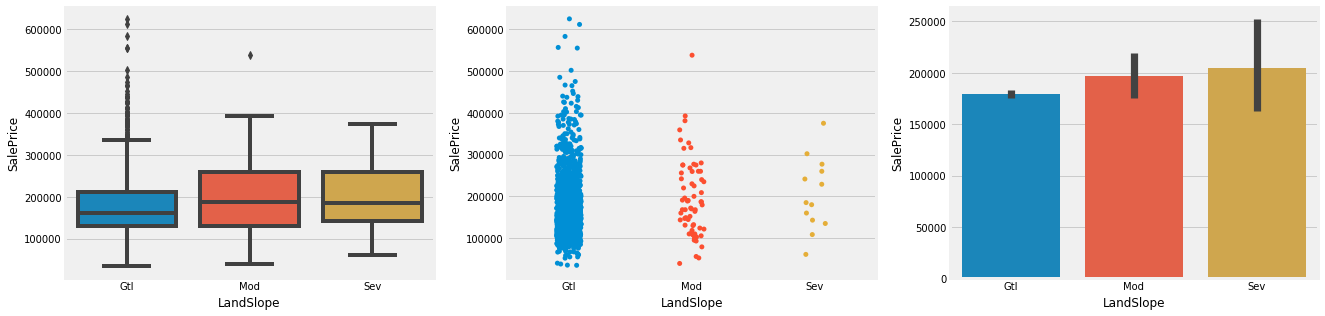

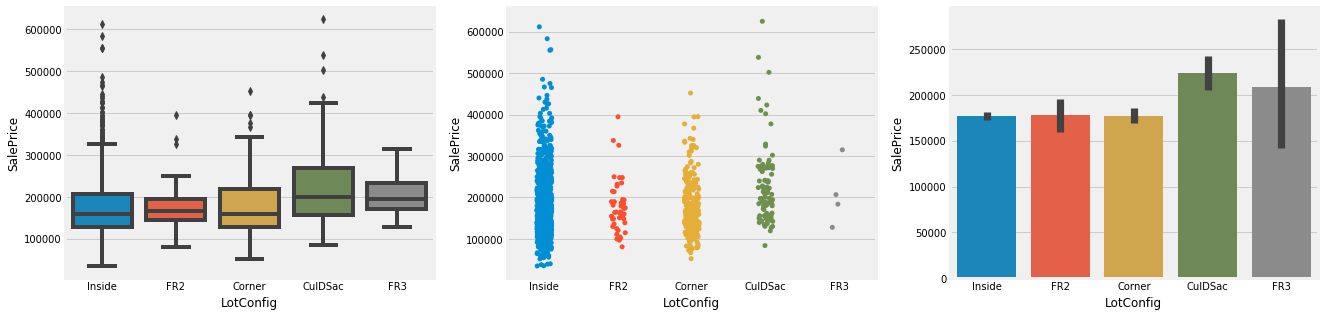

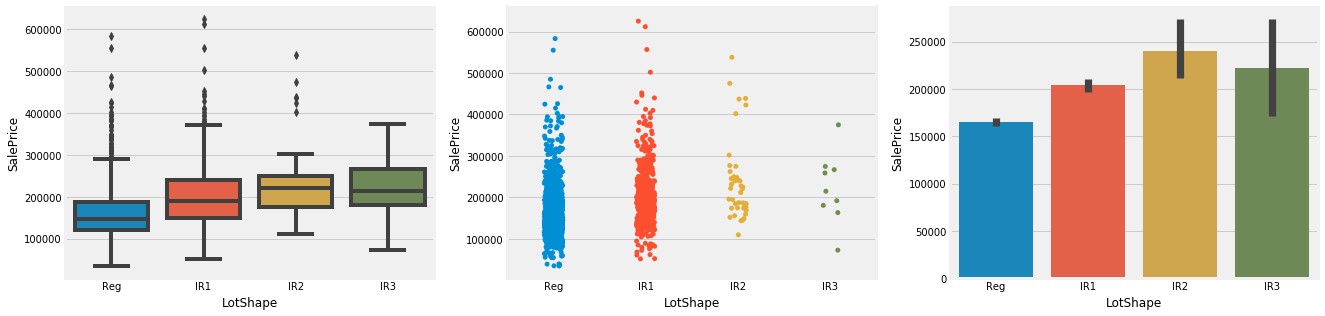

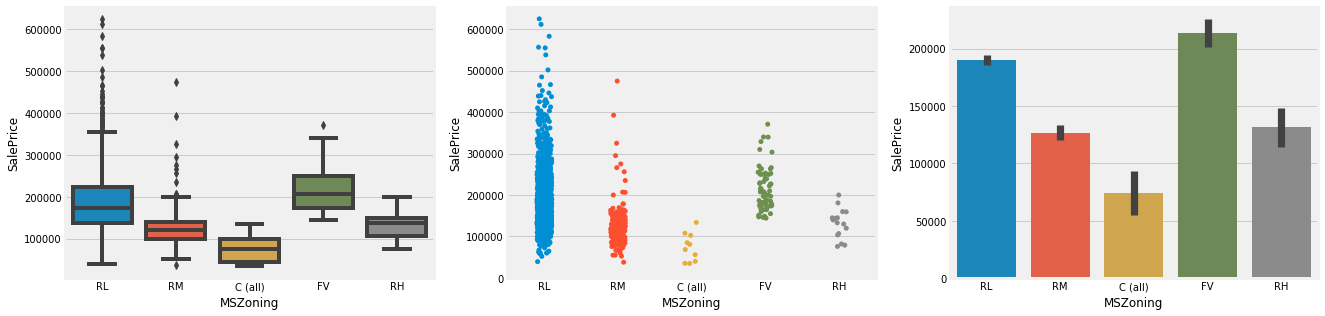

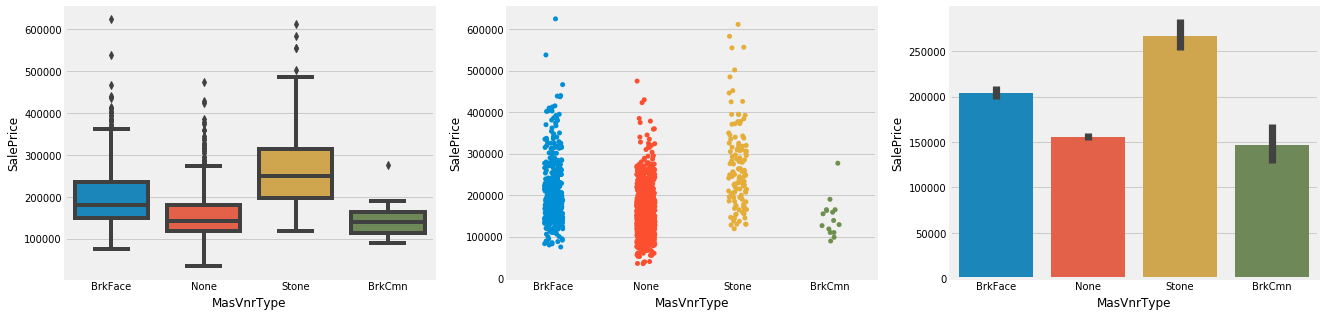

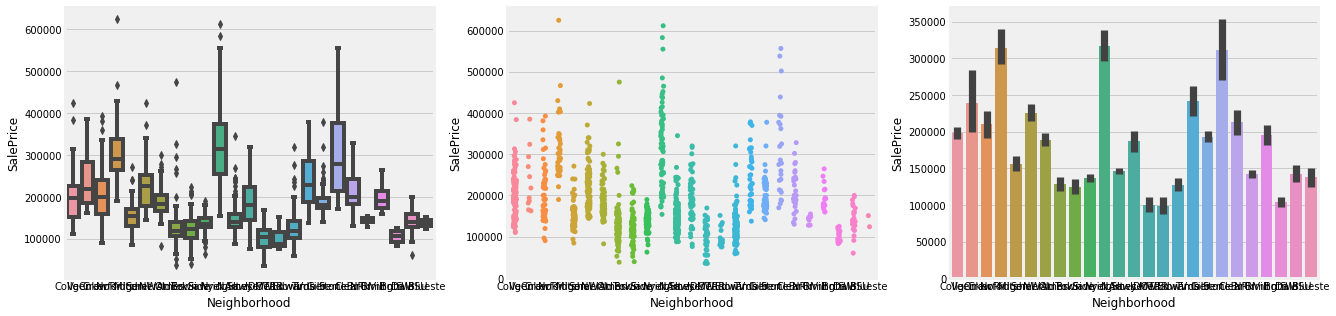

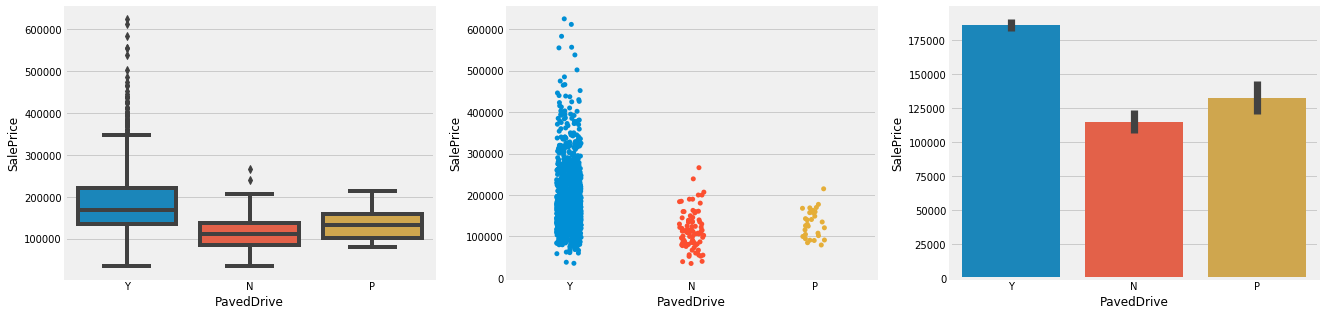

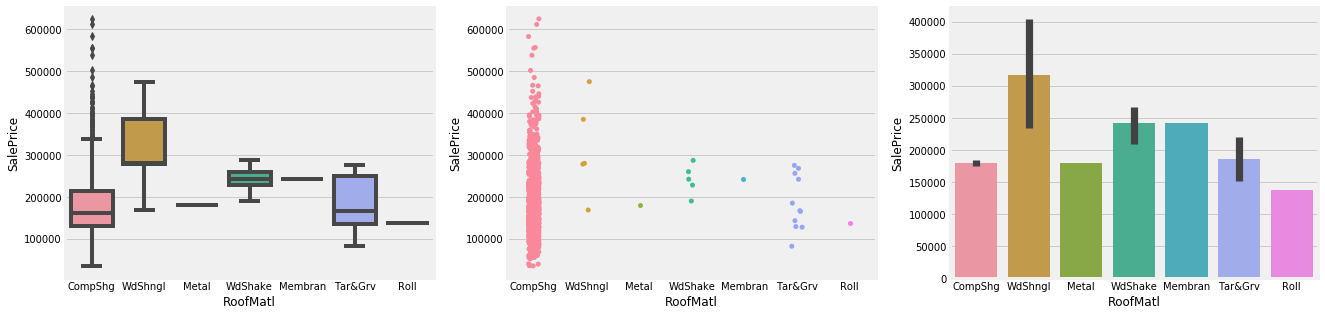

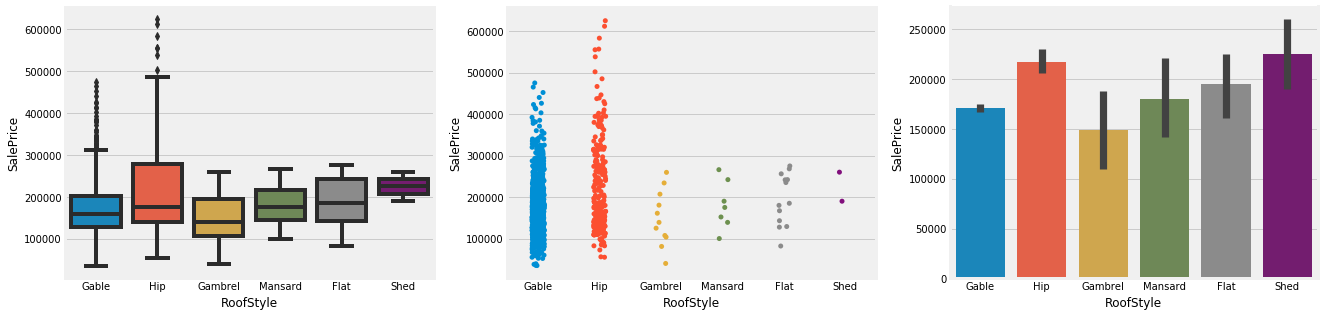

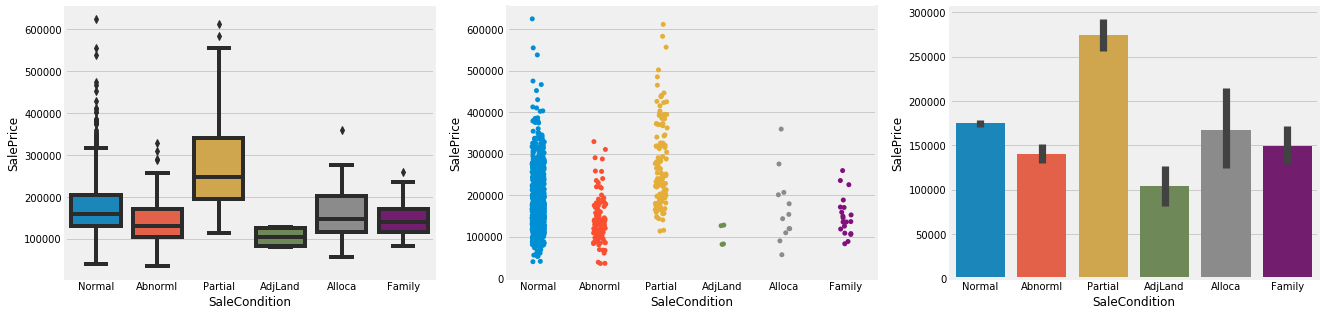

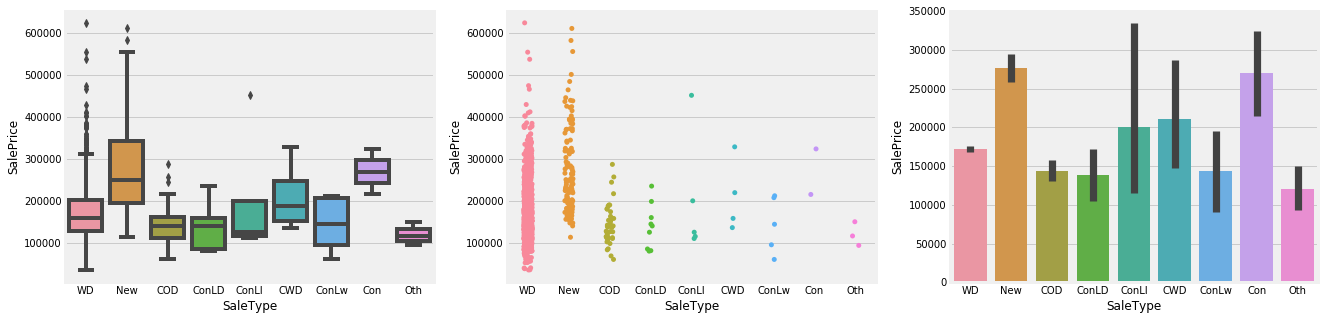

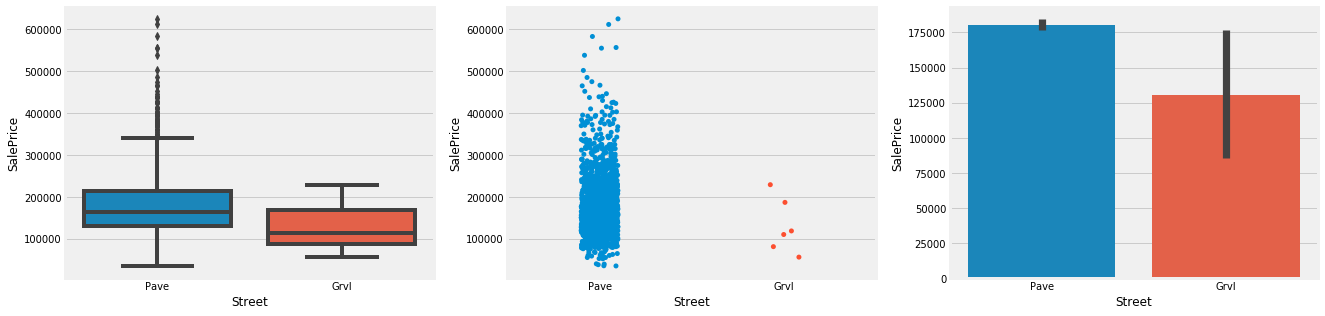

In [17]:
for cat_feature in categorical_features.columns:
    plot_categorical(x=cat_feature,y=TARGET,data=train)

In [18]:
from sklearn.preprocessing import LabelEncoder

for cat_feature in categorical_features.columns:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[cat_feature].values))
    all_data[cat_feature] = lbl.transform(list(all_data[cat_feature].values))

In [19]:
numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Data columns (total 37 columns):
1stFlrSF         2915 non-null int64
2ndFlrSF         2915 non-null int64
3SsnPorch        2915 non-null int64
BedroomAbvGr     2915 non-null int64
BsmtFinSF1       2915 non-null float64
BsmtFinSF2       2915 non-null float64
BsmtFullBath     2915 non-null float64
BsmtHalfBath     2915 non-null float64
BsmtUnfSF        2915 non-null float64
EnclosedPorch    2915 non-null int64
Fireplaces       2915 non-null int64
FullBath         2915 non-null int64
GarageArea       2915 non-null float64
GarageCars       2915 non-null float64
GarageYrBlt      2915 non-null float64
GrLivArea        2915 non-null int64
HalfBath         2915 non-null int64
KitchenAbvGr     2915 non-null int64
LotArea          2915 non-null int64
LotFrontage      2915 non-null float64
LowQualFinSF     2915 non-null int64
MSSubClass       2915 non-null int64
MasVnrArea       2915 non-null float64
MiscVal          2915 

In [20]:
from scipy import stats
from scipy.stats import norm, skew

In [21]:
# Check the skew of all numerical features
skewed_feats = all_data[numerical_features.columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.932147
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.943508
BsmtHalfBath,3.942892


In [22]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 37 skewed numerical features to Box Cox transform


### Checking target for skewness

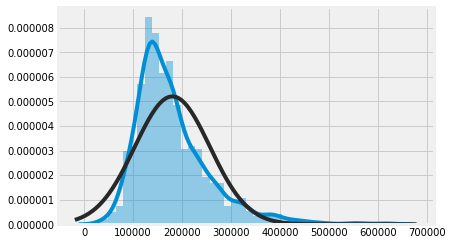

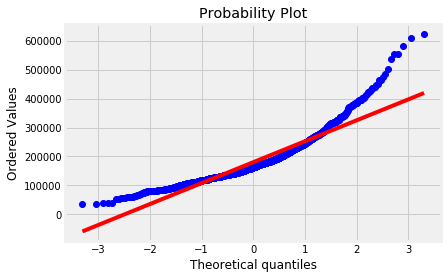

In [23]:
# Explore SalePrice(Target variable)
sns.distplot(y_train , fit=norm);

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

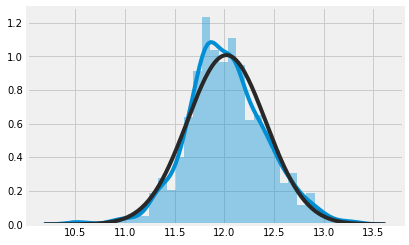

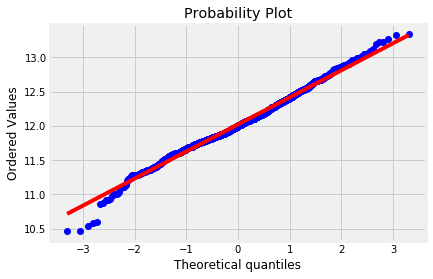

In [24]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
y_train = np.log1p(y_train)

#Check the new distribution 
sns.distplot(y_train , fit=norm);

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

In [25]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [26]:
train.shape,test.shape,y_train.shape

((1456, 75), (1459, 75), (1456,))

In [27]:
train[TARGET] = y_train

In [28]:
train.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF,SalePrice
0,11.692623,11.686189,0.0,1.540963,0,4,3,11.170327,0.0,2,...,0.0,1,2.602594,11.692623,0.000000,14.187527,14.187527,14.195323,14.976591,12.247699
1,12.792276,0.000000,0.0,1.540963,0,4,1,12.062832,0.0,0,...,0.0,1,2.259674,12.792276,9.010206,14.145138,14.145138,14.193765,14.923100,12.109016
2,11.892039,11.724598,0.0,1.540963,0,4,2,10.200343,0.0,2,...,0.0,1,2.259674,11.892039,0.000000,14.184404,14.185966,14.195323,15.149678,12.317171
3,12.013683,11.354094,0.0,1.540963,0,1,3,8.274266,0.0,0,...,0.0,1,2.440268,11.354094,0.000000,14.047529,14.135652,14.192207,14.857121,11.849405
4,12.510588,12.271365,0.0,1.820334,0,4,0,10.971129,0.0,2,...,0.0,1,2.750250,12.510588,8.013884,14.182841,14.182841,14.195323,15.852312,12.429220


In [29]:
test.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF
1456,11.818680,0.000000,0.0,1.194318,0,4,3,10.105326,7.397498,5,...,8,7.020909,1,2.055642,11.775114,7.338607,14.121376,14.121376,14.198437,13.818294
1457,12.943735,0.000000,0.0,1.540963,0,4,3,11.901094,0.000000,0,...,8,0.000000,1,2.259674,12.943735,9.672623,14.116605,14.116605,14.198437,15.091209
1458,11.916131,11.151348,0.0,1.540963,0,4,3,11.476685,0.000000,2,...,8,0.000000,1,2.259674,11.916131,8.232627,14.178149,14.179714,14.198437,14.965191
1459,11.910125,11.062536,0.0,1.540963,0,4,3,10.749651,0.000000,2,...,8,0.000000,1,2.440268,11.910125,9.459637,14.179714,14.179714,14.198437,14.930788
1460,12.833625,0.000000,0.0,1.194318,4,4,3,8.720170,0.000000,0,...,8,7.397498,1,2.055642,12.833625,0.000000,14.170316,14.170316,14.198437,14.968995


In [30]:
train.to_csv("cleaned_data.csv", encoding='utf-8')
test.to_csv("cleaned_data_validation.csv", encoding='utf-8')

## Thanks ...Happy Learning